In [1]:
from config import *

In [2]:
print(f'{year}年{month}月')

2020年4月


# Developer Salary in First-Tier Cities 程序员工资调查
我在4月1日到3日之间，抓取了某招聘网站的软件和互联网类招聘数据40万条，其中通过程序判断为程序员的14万条。地域方面，我选择了24个主要城市。不过本文只以一线城市为研究对象。这样是为了和我2017年6月的数据做对比。

提到2017年的文章，现在居然还有很多人，把这篇文章拿出来炒作。对于社会来说，可气的是，他们直接把2017改成2019，就发表了，这不是骗人么？！对于我来说，可气的是，他们转载居然还冒充是原创，是可忍熟不可忍！

In [3]:
import pandas as pd
import sys
sys.path.append('..')
sys.path.append('../py')
sys.path.append('../../py')
import db
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
import scipy.stats as stats
import numpy as np
import weighted
%matplotlib inline

In [4]:
conn=db.get_conn()
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and city in ('北京','上海','广州','深圳')  and monthly_salary<80000", con=conn)
conn.close()

In [5]:
data=data_original

In [6]:
#del data['publish_date']
#del data['published_on_weekend']
#del data['title']
#del data['title']
#del data['company_title']
#del data['company_description']
#del data['job_description']
#del data['job_id']

In [7]:
data=data.sort_values(by='headcount', ascending=False)
data.head()

,job_id,monthly_salary,headcount,title,zhinengleibie,career,real_province,province,city,company_id,...,bd_hbase,bd_storm,bd_pig,bd_mahout,bd_impala,bd_yarn,bd_alluxio,bd_flink,bd_presto,bd_heron
57944,99101707,10000,500,高薪诚聘专车司机,推荐算法工程师,推荐算法工程师,None,上海,上海,co4768735,...,False,False,False,False,False,False,False,False,False,False
48720,120903677,12500,460,web前端开发,前端开发,前端开发,None,广东,深圳,co5810766,...,False,False,False,False,False,False,False,False,False,False
42221,120372068,9000,280,软件开发、数据分析、产品、设计类岗位,软件工程师,软件工程师,None,异地招聘,上海,co5782817,...,False,False,False,False,False,False,False,False,False,False
42220,120372004,9000,280,软件开发、数据分析、产品、设计类岗位,软件工程师,软件工程师,None,上海,上海,co5782817,...,False,False,False,False,False,False,False,False,False,False
19253,116717167,10000,200,海外业务软件工程师（2020届）,软件工程师,软件工程师,None,上海,上海,co618738,...,False,False,False,False,False,False,False,False,False,False


In [8]:
def pd_weighted_mean(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()


# Unilateral Stats 总体统计

有数据可知，程序员向一线城市集中的趋势非常明显。

According to the statistics, significant amount of developers are in the first tier cities.

In [9]:
data.shape

(58340, 114)

In [10]:
data.headcount.sum()

191275

In [11]:
salary_mean=weighted.weighted_mean(data.monthly_salary.values, data.headcount.values)
q=weighted.weighted_quantile(data.monthly_salary.values,[0.025,0.25,0.5,0.75,0.975], data.headcount.values)
q

array([ 5500., 11500., 14583., 20000., 37500.])

In [12]:
print(f'{year}年{month}月中国一线城市程序员的平均工资为{salary_mean:.0f}元，工资中位数为{q[2]:.0f}元，其中95%的人的工资位于{q[0]:.0f}到{q[4]:.0f}元之间。')

2020年4月中国一线城市程序员的平均工资为16438元，工资中位数为14583元，其中95%的人的工资位于5500到37500元之间。


In [13]:
print(f'In {year}, Developers in China earn {salary_mean:.0f} Yuan as average, '
      f'the median is {q[2]:.0f} Yuan, 95% of them earn between {q[0]:.0f} and {q[4]:.0f} Yuan.')

In 2020, Developers in China earn 16438 Yuan as average, the median is 14583 Yuan, 95% of them earn between 5500 and 37500 Yuan.


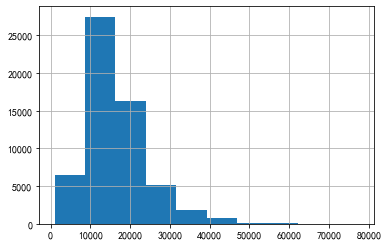

In [14]:
data.monthly_salary.hist()
plt.show()

It does not look like normal distribution.

In [15]:
from scipy import stats

In [16]:
stats.normaltest(data.monthly_salary)

NormaltestResult(statistic=18721.323749298317, pvalue=0.0)

null hypothesis: x comes from a normal distribution
    
p=0

The null hypothesis can be rejected

conclusion: data is not normally distributed.

Zoom in

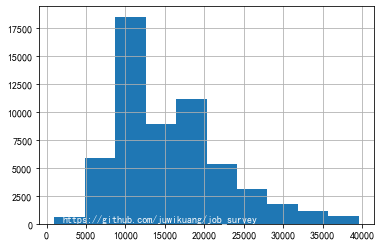

In [17]:
data[data.monthly_salary<40000].monthly_salary.hist()
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0,0), xytext=(2000, 100), color='white')
plt.show()

## Role 角色

In [18]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]
    

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

def get_sub_stats_by_prefix(data, prefix):
    
    features = [feature for feature in data.columns if feature.startswith(prefix)]
    salary_mean=[]
    salary_median=[]
    salary_95_min=[]
    salary_95_max=[]
    count=[]
    
    features_out=[]
    for feature in features:
        #print(feature)
        idata=data[data[feature]==1]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(weighted.weighted_mean(values, weights))
        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_median.append(q[1])
        salary_95_min.append(q[0])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        features_out.append(feature)
    sub_data=pd.DataFrame()
    sub_data['rank']=range(0,len(features_out))
    sub_data[prefix]=[f.replace(prefix,'') for f in features_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_median']=salary_median
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)
    sub_data['rank']=range(1,len(features_out)+1)
    #sub_data=sub_data.reset_index()
    return sub_data

def apply_style(sub_data):
    return sub_data.style.hide_index().format(
    {"salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}","percentage":"{:.2%}"})

In [19]:
data_career = get_sub_stats_by_col(data,'career')
data_career.style.format({"salary_mean":"{:.0f}","salary_median":"{:.0f}","percentage":"{:.2%}"})

,career,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
46,CTO,39288,25000.000000,36250,69041.600000,24,0.01%
39,编译器开发工程师,30697,12500.000000,32500,39604.166667,39,0.02%
14,架构师,28198,11500.000000,27500,54270.250000,3615,1.89%
12,系统架构设计师,27350,7000.000000,28666,45833.000000,1273,0.67%
48,SLAM,26231,12500.000000,30000,30000.000000,13,0.01%
36,芯片,25508,10495.454545,22500,50000.000000,114,0.06%
42,ADAS,24086,10416.000000,26667,45291.350000,26,0.01%
22,机器学习,23818,5250.000000,22500,58333.000000,825,0.43%
5,算法工程师,22302,7500.000000,20833,45000.000000,6564,3.43%
26,图像算法工程师,22119,7000.000000,20000,45000.000000,1174,0.61%


In [20]:
np.sum(data.monthly_salary * data.headcount) / data.headcount.sum()

16437.606482812706

In [21]:
data.headcount.sum()

191275

In [22]:
data.headcount.describe()

count    58340.000000
mean         3.278625
std          5.051038
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        500.000000
Name: headcount, dtype: float64

In [23]:
pd.options.display.max_columns=100


In [24]:
data.headcount.sum()

191275

# 城市

In [25]:
headcount_by_cities = data.groupby(by='city').headcount.sum()

In [26]:
headcount_by_cities


city
上海    64372
北京    32729
广州    44663
深圳    49511
Name: headcount, dtype: int64

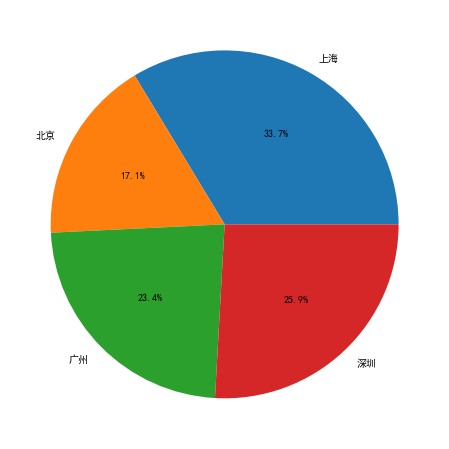

In [27]:
plt.figure(figsize=(10,8))
plt.pie(headcount_by_cities.values, labels=headcount_by_cities.index, autopct='%1.1f%%')
plt.show()

In [28]:
data_pl=get_sub_stats_by_col(data,'city')
apply_style(data_pl)

city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
北京,18058,5250,15500,42500,32729,17.11%
上海,16863,6500,15000,40000,64372,33.65%
深圳,16623,6000,15000,37500,49511,25.88%
广州,14432,5250,12500,30000,44663,23.35%


In [29]:
salary_beijing=data[data.city=='北京'].monthly_salary
salary_shanghai=data[data.city=='上海'].monthly_salary
salary_guangzhou=data[data.city=='广州'].monthly_salary
salary_shenzhen=data[data.city=='深圳'].monthly_salary

In [30]:
stats.f_oneway(salary_beijing, salary_shanghai)

F_onewayResult(statistic=136.33541200192516, pvalue=1.987014554011544e-31)

In [31]:
stats.f_oneway(salary_shanghai, salary_shenzhen)

F_onewayResult(statistic=108.23702744220992, pvalue=2.5924301089284636e-25)

In [32]:
stats.f_oneway(salary_shenzhen, salary_guangzhou)

F_onewayResult(statistic=962.2188095896075, pvalue=5.9553797201273e-208)

# 编程语言

In [33]:
data_pl=get_sub_stats_by_prefix(data,'pl_')
apply_style(data_pl)

rank,pl_,salary_mean,salary_median,salary_95_min,salary_95_max,head_count,percentage
1,rust,22567,25000,4000,45000,458,0.17%
2,scala,22433,20250,8500,50000,2288,0.84%
3,ruby,21497,17500,4604,45000,1769,0.65%
4,matlab,20970,19000,7000,50000,3727,1.37%
5,python,20843,17500,7000,45000,25695,9.42%
6,go,20205,17500,7000,45000,22696,8.32%
7,lua,19792,17500,7000,41597,3505,1.28%
8,perl,19440,17500,5460,49833,1868,0.68%
9,kotlin,19124,17500,9000,37458,761,0.28%
10,r,19109,17500,5250,45000,2858,1.05%


数据显示，haskell才是最赚钱的编程语言。python是主流语言里面最赚钱的，比java的工资多了3000元！vb是最不赚钱的了。其中，最赚钱的编程语言和最不赚钱的，工资居然差了2倍。所以，要选好编程语言呀！

# 教育

In [34]:
edu_counts=data[~(data.edu=='')].groupby(by=['edu']).headcount.sum()

In [35]:
edu_counts

edu
初中及以下        89
博士          834
大专        52821
本科       111288
硕士         6426
高中          890
Name: headcount, dtype: int64

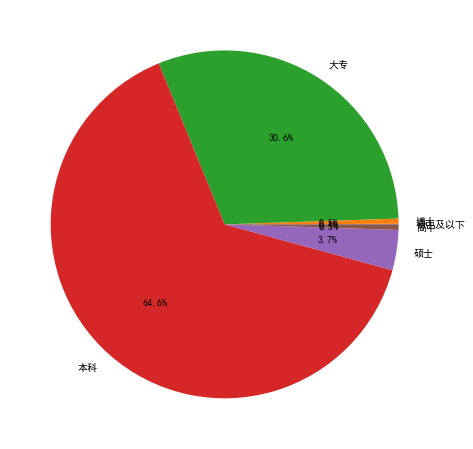

In [36]:
plt.figure(figsize=(10,8))
plt.pie(edu_counts.values, labels=edu_counts.index, autopct='%1.1f%%')
plt.show()

In [37]:
data_edu=get_sub_stats_by_col(data[data.edu.isin(['初中及以下','高中','大专','本科','硕士','博士'])], 'edu')
apply_style(data_edu)

edu,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
博士,25557,1925,25000,50000,834,0.48%
硕士,21533,8000,20000,45000,6426,3.73%
本科,17384,6666,15000,40000,111288,64.57%
大专,14184,5250,12500,27500,52821,30.65%
高中,10375,4000,9000,35000,890,0.52%
初中及以下,7610,3750,7000,18875,89,0.05%


In [38]:
salary_associate=data[data.edu=='大专'].monthly_salary
salary_bachelor=data[data.edu=='本科'].monthly_salary
salary_master=data[data.edu=='硕士'].monthly_salary
salary_phd=data[data.edu=='博士'].monthly_salary

In [39]:
print('大专，本科，硕士，博士的平均工资分别是{:.0f}，{:.0f}，{:.0f}，{:.0f}。中位数分别是{:.0f}， {:.0f}，{:.0f}， {:.0f}。'.format(
    salary_associate.mean(),salary_bachelor.mean(),salary_master.mean(),salary_phd.mean(),
    salary_associate.median(),salary_bachelor.median(),salary_master.median(),salary_phd.median()))

大专，本科，硕士，博士的平均工资分别是13339，17463，22070，26975。中位数分别是12500， 15499，20000， 25000。


In [40]:
stats.f_oneway(salary_phd, salary_master)

F_onewayResult(statistic=46.767711989474115, pvalue=1.0194242794280853e-11)

In [41]:
stats.f_oneway(salary_master, salary_bachelor)

F_onewayResult(statistic=614.4596430531374, pvalue=1.4510494190432017e-134)

In [42]:
stats.f_oneway(salary_bachelor, salary_associate)

F_onewayResult(statistic=3167.936712046677, pvalue=0.0)

经过Oneway Anova Test，证明从大专到博士，学历每提高一级，工资都有显著的提高。

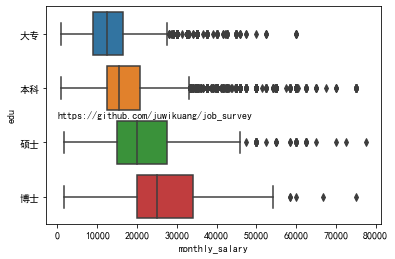

In [43]:

order=['大专','本科','硕士','博士']
a=sns.boxplot(y='edu',x='monthly_salary',order=order,data=data[data.edu.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(0.5,1.5), xytext=(2, 1.55))
plt.show()

# 工作经验 Working Experience

In [44]:
data_experience=get_sub_stats_by_col(data, 'experience')
apply_style(data_experience)

experience,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
10+,31911,12500,30000,60000,675,0.35%
5_10,23101,11500,20500,45000,24928,13.03%
3_5,18060,9000,16500,37500,61571,32.19%
,14052,4750,12500,35000,50801,26.56%
1_3,13525,5500,12500,30000,53300,27.87%


In [45]:
salary_we_10=data[data.experience=='10+'].monthly_salary
salary_we_5_10=data[data.experience=='5_10'].monthly_salary
salary_we_3_5=data[data.experience=='3_5'].monthly_salary
salary_we_1_3=data[data.experience=='1_3'].monthly_salary
salary_we_no=data[data.experience=='no'].monthly_salary

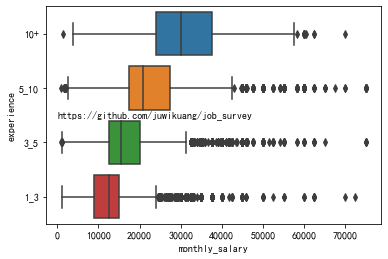

In [46]:

order=['10+','5_10','3_5','1_3']
sns.boxplot(y='experience',x='monthly_salary',order=order,data=data[data.experience.isin(order)], orient='h')
plt.annotate('https://github.com/juwikuang/job_survey', xy=(1.5,1.5), xytext=(1.55, 1.55))
plt.show()

# 公司 Company

## 公司性质 Company Type

In [47]:
data_company_type=get_sub_stats_by_col(data,'company_type')
apply_style(data_company_type)

KeyError: 'company_type'

us_eu是欧美外企，startup是创业公司，listed是上市公司，state是国企，private是私企，foreign是非欧美外企，其他不足1000个样本的不管了。

## 公司规模 Company Size

In [ ]:
data_company_size=get_sub_stats_by_col(data,'company_size')
apply_style(data_company_size)

公司越大，工资越高

## 行业 Industry

In [ ]:
data_industry=get_sub_stats_by_col(data,'industry')
apply_style(data_industry)